# QA simulation of vacancies in graphene explained

## The model

In this tutorial, we are going to use a simple model to calculate the energy of vacancies in graphene.

**The material**

The chemical system we are going to study is a graphene sheet. In order to be able to calculate the energy of up to three vacancies, we are going to use a 3x3 supercell of the primitive cell.

Let's first build the system. For this task we are going to be using a python library called pymatgen. pymatgen is a very powerful tool developed as part of the Materials Project. It can be used to create, modify, analyse 3D systems. Don't worry if you are not familiar with pymatgen, we are only going to use it to generate the structure and every step is explained.

First we need to import the two objects that we are going to use to generate the graphene structure, which is called Structure:

In [1]:
from pymatgen.core.structure import Structure

We are going to use numpy to define the lattice as a 3x3 matrix:

In [4]:
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

The Structure object requires three pieces on informations: the lattice, the species and the fractional coordinates of these species in the cell defined by lattice. So, we are going to create and inspect what information is in the graphene object by displaying it.

In [12]:
graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
display(graphene)

Structure Summary
Lattice
    abc : 2.4677242827325747 2.4677242827325747 8.685038
 angles : 90.0 90.0 120.00000758003493
 volume : 45.80317575176706
      A : 1.233862 -2.137112 0.0
      B : 1.233862 2.137112 0.0
      C : 0.0 0.0 8.685038
PeriodicSite: C (1.2339, -0.7124, 0.0000) [0.6667, 0.3333, 0.0000]
PeriodicSite: C (1.2339, 0.7124, 0.0000) [0.3333, 0.6667, 0.0000]

The supercell can be created by using the pymatgen make_supercell function. First we need to define the expansion matrix:

In [17]:
import copy 

expansion_matrix = np.array([[3, 0, 0],
                            [0, 3, 0],
                            [0, 0, 1]])

graphene_supercell = copy.deepcopy(graphene)

graphene_supercell.make_supercell(expansion_matrix)

display(graphene_supercell)

Structure Summary
Lattice
    abc : 7.403172848197724 7.403172848197724 8.685038
 angles : 90.0 90.0 120.00000758003493
 volume : 412.2285817659035
      A : 3.701586 -6.411336 0.0
      B : 3.701586 6.411336 0.0
      C : 0.0 0.0 8.685038
PeriodicSite: C (1.2339, -0.7124, 0.0000) [0.2222, 0.1111, 0.0000]
PeriodicSite: C (2.4677, 1.4247, 0.0000) [0.2222, 0.4444, 0.0000]
PeriodicSite: C (3.7016, 3.5619, 0.0000) [0.2222, 0.7778, 0.0000]
PeriodicSite: C (2.4677, -2.8495, 0.0000) [0.5556, 0.1111, 0.0000]
PeriodicSite: C (3.7016, -0.7124, 0.0000) [0.5556, 0.4444, 0.0000]
PeriodicSite: C (4.9354, 1.4247, 0.0000) [0.5556, 0.7778, 0.0000]
PeriodicSite: C (3.7016, -4.9866, 0.0000) [0.8889, 0.1111, 0.0000]
PeriodicSite: C (4.9354, -2.8495, 0.0000) [0.8889, 0.4444, 0.0000]
PeriodicSite: C (6.1693, -0.7124, 0.0000) [0.8889, 0.7778, 0.0000]
PeriodicSite: C (1.2339, 0.7124, 0.0000) [0.1111, 0.2222, 0.0000]
PeriodicSite: C (2.4677, 2.8495, 0.0000) [0.1111, 0.5556, 0.0000]
PeriodicSite: C (3.7016, 4.9

Please find below an image of the supercell where the atom index has been reported on the atom itself.

[graphene_primitive_cell](images/graphene_primitive_cell.png)

As a note for non experts in materials science, the cell reported here has 2-dimensional periodicity, also called periodic boundary conditions. This means it is repeated periodically, effectively representing an infinite graphene sheet. The image below shows a 3x3 supercell of the graphene supercell used in this notebook. 

[graphene_super_cell](images/graphene_super_cell.png)

This is going to become relevant later in the definition of the model.

From the graphene_supercell structure displayed above, you can see the structure now containins 18 atoms and the lattice parameters a and b are three times as large as the primitive cell ones.

Now, let's start defining the vectors and matrices that we will use to represent the system.
First we are going to create the vector **c**. This is the vector that we are going to use to identify atom positions in the system. It will contain, therefore, numbers from 0 to the total number of atoms:

In [22]:
c = np.arange(graphene_supercell.num_sites)
display(c)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

To do so, we used the numpy arange function and the num_sites attribute of the graphene_supercell Structure object to define the upper bound.

We are also going to define the vector **x**. This is a binary vector where:
- $x_{i}$ = 1 if atom i is present
- $x_{i}$ = 0 if atom i has been replaced by a vacancy

At first we are going to define the structure containing no vacancies, so $x_{i}$ = 1 for all $i$

In [23]:
x = np.array([1]*graphene_supercell.num_sites)
display(x)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Because in the model we are using, the energy depends on the number of bonds, we need a way to identify bonded atoms. To do so, we are going to start with the distance_matrix, which is a property of the graphene_supercell object:

In [25]:
graphene_sc_distance_matrix = graphene_supercell.distance_matrix
display(graphene_sc_distance_matrix)

array([[0.        , 2.46772428, 2.46772428, 2.46772428, 2.467724  ,
        4.27422351, 2.46772428, 4.27422351, 2.467724  , 1.42474133,
        3.769511  , 1.42474117, 1.42474117, 2.84948234, 2.84948267,
        3.769511  , 3.7695107 , 2.84948234],
       [2.46772428, 0.        , 2.46772428, 4.27422351, 2.46772428,
        2.467724  , 2.467724  , 2.46772428, 4.27422351, 1.42474117,
        1.42474133, 3.769511  , 2.84948267, 1.42474117, 2.84948234,
        2.84948234, 3.769511  , 3.7695107 ],
       [2.46772428, 2.46772428, 0.        , 2.467724  , 4.27422351,
        2.46772428, 4.27422351, 2.467724  , 2.46772428, 3.769511  ,
        1.42474117, 1.42474133, 2.84948234, 2.84948267, 1.42474117,
        3.7695107 , 2.84948234, 3.769511  ],
       [2.46772428, 4.27422351, 2.467724  , 0.        , 2.46772428,
        2.46772428, 2.46772428, 2.467724  , 4.27422351, 3.769511  ,
        3.7695107 , 2.84948234, 1.42474133, 3.769511  , 1.42474117,
        1.42474117, 2.84948234, 2.84948267],
    

In graphene_sc_distance_matrix, the element in position $i,j$ is the distance (in Å) between atom $i$ and atom $j$.

Next we will create a list of unique distances contained in the graphene_sc_distance_matrix to identify the number of "shells" an atom has. We will do so by using numpy:

shells = np.unique(distance_matrix_pbc[0])
display(shells)

In [29]:
shells = np.unique(np.round(graphene_sc_distance_matrix[0],5)) 
display(shells)

array([0.     , 1.42474, 2.46772, 2.84948, 3.76951, 4.27422])

In this model, we are only interested in the nearest neighbours, i.e. the ones in the first coordination shell, which corresponds to the element in position 1 of the array above (remember that in python we start counting from 0). Therefore, we can combine the information contained in the graphene_sc_distance_matrix and shells arrays to generate the adjacency matrix:

In [34]:
adjacency_matrix = (np.round(graphene_sc_distance_matrix,5) == shells[1]).astype(int)
display(adjacency_matrix)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In adjacency_matrix:
- the element in position $i,j$ = 1 if atoms $i$ and $j$ are bonded
- the element in position $i,j$ = 0 if atoms $i$ and $j$ are not bonded

We can verify this for the atom 0. Let's look at the position of the 1s in the first line of the adjacency_matrix:

In [37]:
np.where(adjacency_matrix[0] == 1)[0]

array([ 9, 11, 12])

We can see that atom 0 is bound to atoms 9, 11 and 12. This is confirmed by looking at the image above, where we can see that atoms 9 and 11 are next to atom 0. Atom 12 is at the other end of the cell and this is where the periodic boundary conditions (or 2D periodicity is included in the model). By saying that atom 0 and 12 are bonded, we are saying that once we get to the end of the cell, we start back from the opposite side (explain better).

## Classical approach

What is meant by "Classical approach" is that we are going to follow the usual workflow in computational materials chemistry:

- define the system
- define the model used to describe the model
- define the model used to calculate the energy of the system
- calculate the energy

The system and the model to represent it were described above in terms of **c** and **x** vectors and the **adjacency_matrix**.

We are going to start by defining a very simple model to calculate the energy of the system:

- each bond decreases the energy by 1 a.u. (arbitrary unit)

Therefore, the task will be finding out how many bonds there are in the system. 

A very simple way to achieve this would be counting how many 1s there are in the adjacenty_matrix and divide that number by two because this procedure counts the bond between $i$ and $j$ and the bond between $j$ and $i$ as two separate bonds. Let's see how we could do this:

In [43]:
num_bonds = np.sum(adjacency_matrix)/2
display(num_bonds)

27.0

The above described procedure works well if there are no vacancies in the system. Let's think about a way to describe systems with vacancies.

We are going to start by multiplying the **x** vector by the **adjacency_matrix** and call this intermediate result **r**:

In [47]:
r = np.matmul(x,adjacency_matrix)
display(r)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

The vector **r** has length number of atoms in the supercell. The element $r_{i}$ tell us how many atoms the atom $i$ is bonded to.

Now we are going to multiply $\bf x^{T}$ by **r** and multiply by -1 and divide the final result by 2 to obtain the energy:

In [52]:
E = -0.5 * np.matmul(x,r)
display(E)

-27.0

### 1 vacancy

Let's now simulate systems with 1 vacancy. At first we will introduce the vacancy in position 0. To achieve this, we will replace the 1 in position 0 of the x vector by a 0:

In [54]:
x[0] = 0
display(x)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

We will calculate the energy of the system following the same procedure used above, but this time we will perform both steps at once:

$$
E = - 0.5 \  \bf x^{T} * \ adjacency\_matrix * \ x
$$

In [56]:
E = - 0.5 * np.matmul(x,np.matmul(x,adjacency_matrix))
display(E)

-24.0

As expected, one vacancy removes 3 bonds and, therefore, the energy went up by 3 a.u.

Because of the symmetry of the system and the way the model is built, all atom positions are equivalent. This means that a vacancy in any position will increase the energy by 3 a.u., but let's confirm this.

Let's build a matrix, called **X**, where each row represents a possible position for the vacancy:

In [115]:
X = np.array([[1]*graphene_supercell.num_sites]*graphene_supercell.num_sites)
np.fill_diagonal(X,0)

In [100]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In the **X** matrix, the row $i$ represents the configuration with the vacancy in the $i-th$ position.

We could now procede to calculate the energy of each configuration using a for loop, i.e. multiply each line by the adjacency_matrix and then again by the transposed line. Let's do this in the cell below and use a faster approach later:

In [116]:
energies = []
for line in X:
    energies.append(np.matmul(line, np.matmul(line, adjacency_matrix)))

display(energies)

[48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]

As expected, the energy if the same for each configuration. In the **energies** vector above, the element $e_i$ is the energy of the configuration $i$.

The faster approach mentioned above consists in using linear algebra knowledge and multiply the **X** matrix by the **adjacency_matrix** directly:

In [113]:
#REVIEW THIS
energies = - np.matmul(X,adjacency_matrix)
energies = np.sum(adjacency_matrix,axis = 1)
display(energies)

#E_tmp = -np.matmul(X_classical,adjacency_matrix)
#E_classical = np.sum(X_classical*E_tmp,axis=1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

The energy landscape as a function of the configuration is plotted below:

array([ 1.        , -0.64014434, -0.18043045,  0.8711474 , -0.93488971,
        0.32578131,  0.51779559, -0.98870914,  0.74803752,  0.03100516,
       -0.78773308,  0.97752059, -0.46377546, -0.38375412,  0.95509151,
       -0.83903873,  0.11912028,  0.68653039])

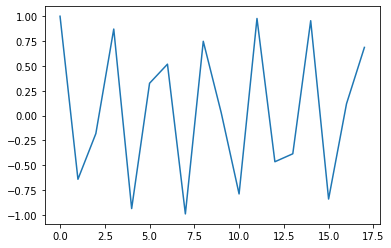

In [126]:
import matplotlib.pyplot as plt

x = np.arange(18)
y = np.cos(x*energies)
plt.plot(x,y)
y

As the final step of this "classical approach", we are going to calculate the energy of all possible configurations and number of vacancies. There will be $2^{num_atoms}$, so $2^{18} = 262144$ possible configurations. The new **X** matrix that contain all of them will be generated by using a python module called itertools. The first 10 configurations are displayed below.

In [93]:
import itertools
X = np.array(list(itertools.product([0, 1], repeat=18)))
X[0:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]])

Now we are going to use the same approach discussed above to calculate the energy of all the configurations. 

In [105]:
energies = - np.sum(X*np.matmul(X,adjacency_matrix), axis=1)
energies

array([  0,   0,   0, ..., -48, -48, -54])

Let's now have a look at the unique energies for the set:

In [111]:
energies_unique, count = np.unique(energies, return_counts=True)
display(energies_unique)
display(count)

array([-54, -48, -44, -42, -40, -38, -36, -34, -32, -30, -28, -26, -24,
       -22, -20, -18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   0])

array([    1,    18,    27,   126,    54,   324,   564,   729,  1728,
        2367,  4023,  6048,  8757, 12204, 16686, 20454, 25542, 28701,
       30276, 30402, 26919, 21267, 14904,  7425,  2598])

In the cell above, the first array reports the unique energies, whereas, the second one reports how many structures corresponding to a certain energies were found.

## Quantum annealing

In this section we are going to use a quantum annealer to find the lowest energy/energies structures for a certain configuration.

This approach, opposite to the "classical approach", will consist of:

- define the system 
- define the model to represent the system
- encode both the model to represent the system and the energy model into a binary quadratic model (explain below)
- run the annealing N times and analyse the results (energy and configuration)

The important difference to notice with respect to the "Classical model" is that instead of defining the model to represent the system, we are encoding that information into the binary quadratic model that, by trying to find the lowest energy solution, will return both the energy of the system and the corresponding configuration. Therefore, we are still going to use the **c** vector, but the **x** vectors will be returned by the calculation.

### The Binary Quadratic Model

The binary quadratic model can be expressed as:

$$
E = \sum_{i} h_{i} x_{i} + \sum_{i,j} x_{i}x_{j}
$$

where, in the context of quantum annealing computing:

- $h_i$ is called bias 
- $J_{i,j}$ is called coupling

The bias corresponds to the 

# THE END

In [39]:
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize import view
view(AseAtomsAdaptor().get_atoms(graphene_supercell))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>